## Detecting the Railings of a Track Using a Stereo Vision Camera

This document describes the steps taken to detect the railing of a small track as well as to know the distance from the railing.

In [1]:

%matplotlib inline

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import scipy.misc

In [2]:
print ("Current working dir : %s" % os.getcwd())

Current working dir : C:\Users\Adam\git_personal\Track-Detection-Using-Stereo-Depth


### Example of Depth Image

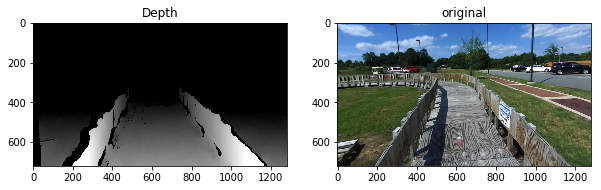

In [5]:
test = 'Images\image_depth_444.jpg'
dpt = cv2.imread(test)
original = cv2.imread('Images\image_left_444.jpg')
# print(original,"original")
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) # cv2 reads in images as BGR


%matplotlib inline
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.set_title('Depth')
ax1.imshow(dpt)
ax2.set_title('original')
ax2.imshow(original)

Original Image            |  Depth Image
:-------------------------:|:-------------------------:
![](Images/image_Left_444.jpg)  |  ![](Images/image_Depth_444.jpg)

### Perspective transform
The perspective trasform is used to convert from pixel coordinates to real world coordinates.
Although the ZED Sdk can provide a 3D point cloud with real wold coordinates it will be interesting to compare the accuracy between the two methods.

Once the railing is detected its distance from the center of the vehicle can be determined using the perspective transform.

In [6]:
# This method returns the perspective transform matrix and its inverse
def get_M_Minv(img):
    img_size = (img.shape[1],img.shape[0])  
    src = np.float32( # pixel coordinates
    [[478, 615],
    [624, 306],
    [726, 310],
    [891, 630]]) 
    dst = np.float32( # real word coordinates in inches
    [[-24,72],
    [-24, 248+72],
    [24, 248+72],
    [24, 72]])
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src,dst)    
    Minv = cv2.getPerspectiveTransform(dst,src)   
    return M, Minv

# For visualization purposes only
# Because 0 starts at the top of the image and left most pixel is zero. 
# For real perspective transform we want bottom center of th image to be 0, 0 inches
def get_M_MinvVis(img):
    img_size = (img.shape[1],img.shape[0])  
    src = np.float32(
    [[478, 615],
    [624, 306],
    [726, 310],
    [891, 630]]) 
    dst = np.float32(
    [[216,260],
    [216, 12],
    [264, 12],
    [264, 260]])
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src,dst)    
    Minv = cv2.getPerspectiveTransform(dst,src)   
    return M, Minv

# gets perspective transformed image
def warp(img, M, img_size ):    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# unwarps the image back to original
def unWarp(img, Minv):
    img_size = (img.shape[1],img.shape[0])    
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unWarped

1280 720


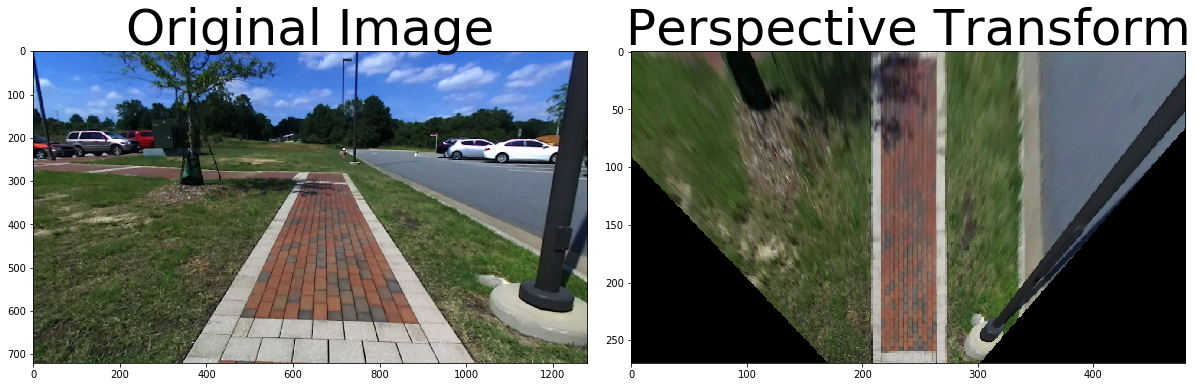

In [9]:
test = 'Pictures/perspective_cal.jpg'
image = cv2.imread(test)
%matplotlib inline


img_size = (image.shape[1],image.shape[0])
# only used for visualization
Mvis, Minvvis = get_M_MinvVis(image)
# to convert pixels to inches use 
M, Minv = get_M_Minv(image)

# get perspective transform of image
warped = warp(image,Mvis,(480, 270))
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
warpRGB = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(imageRGB)

ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warpRGB)
ax2.set_title('Perspective Transform', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print(img_size[0] ,img_size[1])
scipy.misc.imsave("Pictures/Transformed_Image.jpg", warpRGB)

Calibration Image          |  Birds Eye View Pespective Transform
:-------------------------:|:-------------------------:
![](Pictures/perspective_cal.jpg )  |  ![](Pictures/Transformed_Image.jpg )

In [10]:
M = np.array([[ -2.72856341e-01,   8.56199838e-03,   1.81547469e+02],
       [ -3.46017550e-04,   5.23860756e-02,  -2.01215341e+02],
       [  2.25802375e-04,  -5.62182736e-03,   1.00000000e+00]])
Minv = np.array([[  7.54893714e+01,   7.20171427e+01,   7.86049637e+02],
       [  3.15507435e+00,   2.19615255e+01,   3.84620008e+03],
       [  6.91603907e-04,   1.07202263e-01,   1.00000000e+00]])

In [11]:
# This function draws a line on the railing where it is detected
def markTrackLine(image, right_fit,Minv):
    # y points to mark line 0 to 140 inches
    ploty = np.linspace(0, 140, num=141) 
    
    # get points on line 
    right_fitx = right_fit[0] * ploty+ right_fit[1]
    
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))], np.float32) 
    # convert back to pixel coordinates
    xformed = cv2.perspectiveTransform( np.array(pts), Minv).astype(np.int32)

    cv2.polylines(color_warp,xformed,False,(0,0,255),20)
    result = cv2.addWeighted(image, 1, color_warp, 0.5, 0)

    return result

# This function takes in the colmn indeces of the detected points and outputs a list of row, column pixel values
# points on left or Right side of image are excluded
def getCoords(indices):
    return([ row for row,col in enumerate(indices.tolist()) if col != 0 and col != 1279 ], \
           [ col for row,col in enumerate(indices.tolist()) if col != 0 and col != 1279])

### Function that Filters the Depth Image and Generates the Polyfit Line

This simple code functions quite well. It was the basis for the final c++ code.

In [15]:
# single frame
# crop bottom of image
def generate_line(depth):

    # convert depth image to grayscale
    gray = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
    # used to crop lower part of image as this portion of the depth image sometimes distored due to being too close
    crop_low = np.zeros_like(gray)
    # only interested in right side of track
    right = np.zeros_like(gray)
    binary = np.zeros_like(right)

    # threshold grayscaled depth image, depth further than 100 pixel value considered 0 all others considered 1
    binary[gray > 100] = 1
    
    # crop bottom portion of image
    crop_low[:650,:] = binary[:650,:]
    # right side of gradient    
    right[:,640:] = crop_low[:,640:]

    # calculates right most pixel columns
    cols = np.argmax(np.fliplr(right)==1, axis = 1)
    # convert to image pixels
    coords= getCoords(cols)
    # create blank image
    test = np.zeros_like(right)
    # mark detected pixels as 1
    test[coords[0],coords[1]] = 1
    # flip pixels back to original orientation
    test = np.fliplr(test)
    

    # run dilate on detected pixels to make line more prominant 
    kernel = np.ones((5,5),np.uint8)
    # dilation just used for visualization, does not improve performance
    test = cv2.dilate(test,kernel,iterations = 2)
    
    # get indeces of nonzero pixels, could also rearange coords instead of this function
    nonzero = test.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]

    single = np.vstack((nonzerox,nonzeroy)).T 
    # convert detected pixel courdinates to real world x, y coordinates in inches using perspective transform
    single_xf = cv2.perspectiveTransform(np.array([single.astype(np.float32)]),M)# needs x first y second tom match M matrix
    single_xf = single_xf[0]
    
    # needs y first x second
    line = np.polyfit(single_xf[:,1],single_xf[:,0], 1)  
    return line

### Main Loop
#### Detect Track Edge
#### Draw on original image and save processed Image

In [14]:
import csv
import re
import scipy.misc
import math
from numpy.linalg import inv

# Perspective transform matrix that converts pixels to real world coordinates
M = np.array([[ -2.72856341e-01,   8.56199838e-03,   1.81547469e+02],
       [ -3.46017550e-04,   5.23860756e-02,  -2.01215341e+02],
       [  2.25802375e-04,  -5.62182736e-03,   1.00000000e+00]])
# 
Minv = np.array([[  7.54893714e+01,   7.20171427e+01,   7.86049637e+02],
       [  3.15507435e+00,   2.19615255e+01,   3.84620008e+03],
       [  6.91603907e-04,   1.07202263e-01,   1.00000000e+00]])

# read in images
image_names = glob.glob('Images//image_left_*.jpg') 
depth_names = glob.glob('Images//image_depth_*.jpg') 

# folder to save processed images in case want to make video
processed ='processed/'

# Sort incoming images
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

image_names = sorted(image_names, key=numericalSort)
depth_names = sorted(depth_names, key=numericalSort)

loopn=0


shift = 0

# all we really need returned from this is the line_ variable to use for controlling the vehicle
for image, depth in zip(image_names, depth_names):
 
    dpt_ = mpimg.imread(depth)
    img_ = mpimg.imread(image)

    line_ = generate_line(dpt_)
    
    result = markTrackLine(img_, line_, Minv)
    
    # only for saving images for visualization later
    scipy.misc.imsave(processed +  "detected_" +  "%04d" % loopn + '.png', result)

    loopn = loopn + 1
    if loopn%100 == 0:
        print(loopn)

100


### Video Creation of Processed Images

In [38]:
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

vid_output = 'line.mp4'
cwd = os.getcwd()
print(cwd)
os.chdir(cwd + '/processed')
clips = glob.glob('*.png')  

#     image = mpimg.imread(clip)
clip = ImageSequenceClip(clips,fps=30)
# lane_clip = clip.fl_image(track_pipelineV)
clip.write_videofile(vid_output, audio=False)

os.chdir(cwd)

C:\Users\Adam\git_personal\Track-Detection-Using-Stereo-Depth
[MoviePy] >>>> Building video line.mp4
[MoviePy] Writing video line.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:05<00:00, 21.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: line.mp4 



### Additional Efforts with Higher Order Polynomials, Including Multiple Frames, and Using Visual Odometry
In the end none of the below code was used. The linear fit on a single image was most practical.

In [39]:
# This function take drawes a shaded green region to mark the lane
def markTrackShift(image, right_fit,Minv,shift=0):
    # y points to mark line 0 to 140 inches
    ploty = np.linspace(0, 140, num=141)    
#     print("right base", right_fit[2])
    
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] - shift
    

    color_warp = np.zeros_like(image).astype(np.uint8)
    pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))], np.float32)
    
    xformed = cv2.perspectiveTransform( np.array(pts), Minv).astype(np.int32)

    cv2.polylines(color_warp,xformed,False,(255,0,0),20)

    result = cv2.addWeighted(image, 1, color_warp, 0.5, 0)

    return result

### Generate Images Pipeline for Higher Order Polyfits using Multiple Images
This part of the code does all of the filtering of the depth image

In this code multiple frames are used to determine the polynomial fit.
The visual odometry from the Zed stereo camera is used to shift the previous points by the amount that the camera moved from the previous frame. 

Ultimately the results were only a minor improvement to the original but the code may be useful in the future.

In [44]:
### uses 2nd order polynomial
# multiframe
# positive x to right positive y out in front
# crop bottom of image
# shift back previous points
def generate_poly_odom9(depth, dx, dy):
    global loopn
    global frames
    global recent_x
    global recent_y

    dpt = depth

    gray = cv2.cvtColor(dpt, cv2.COLOR_BGR2GRAY)
    crop_low = np.zeros_like(gray)
    right = np.zeros_like(gray)
    binary = np.zeros_like(right)

    binary[gray > 100] = 1
    
    # right side of gradient
    crop_low[:650,:] = binary[:650,:]
    right[:,640:] = crop_low[:,640:]
    
    cols = np.argmax(np.fliplr(right)==1, axis = 1)
#     cols = np.where(right==1)
    coords= getCoords(cols)
    test = np.zeros_like(right)
    test[coords[0],coords[1]] = 1
    test = np.fliplr(test)
    
    kernel = np.ones((5,5),np.uint8)
    test = cv2.dilate(test,kernel,iterations = 2)

# you may want to keep the transformed points in the end so you can shift them by real odometry
    nonzero = test.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
#     nonzero = np.vstack(nonzero).T

    single = np.vstack((nonzerox,nonzeroy)).T 
    single_xf = cv2.perspectiveTransform(np.array([single.astype(np.float32)]),M)# needs x first y second tom match M matrix
    single_xf = single_xf[0]

    if recent_x:
        recent_x[:] = recent_x[:] 
        recent_y[:] = recent_y[:] - dy
    if(len(recent_x)<frames):
        recent_x.append(single_xf[:,0])
        recent_y.append(single_xf[:,1])
    else:
        recent_x[loopn%frames] = single_xf[:,0]
        recent_y[loopn%frames] = single_xf[:,1]

    arrayx = np.concatenate(recent_x)
    arrayy = np.concatenate(recent_y)    
    
    combined = np.vstack((arrayx,arrayy)).T    

    # needs y first x second
    poly = np.polyfit(combined[:,1],combined[:,0], 2)  
    line = np.polyfit(combined[:,1],combined[:,0], 1)  
    return poly, line

### Read Zed odometry from csv file 

In [45]:
def readOdomCSV(filename):
    odom = np.loadtxt(filename, dtype=np.float32,  delimiter=",", converters=None, skiprows=1, usecols=[2,4, 10], unpack=False, ndmin=0)
    # Convert to inches from m
    odom[:,0] = odom[:,0]*39.3701 
    odom[:,1] = odom[:,1]*-39.3701 # convert what was -z for zed to +y 
    
    
    return odom



#### Main Code for Second Order Polyfit

In [43]:
import csv
import re
import scipy.misc
import math
from numpy.linalg import inv
# get perspective transform matrices
test = 'Images//image_left_444.jpg'
image = cv2.imread(test)
img_size = (image.shape[1],image.shape[0])
M, Minv = get_M_Minv(image)


# yminimum = 500
image_names = glob.glob('Images//image_left_*.jpg') 
depth_names = glob.glob('Images//image_depth_*.jpg') 

processed ='processed/'
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

image_names = sorted(image_names, key=numericalSort)
depth_names = sorted(depth_names, key=numericalSort)


# read in odometry from zed camera
odom = readOdomCSV("Images//track_odom.csv")    
# convert odometry to robot reference frame
# prev_x and prev_y originally set as origin
prev_x = odom[0,0]*np.cos(odom[0,2]) + odom[0,1]*np.sin(odom[0,2])
prev_y = -odom[0,0]*np.sin(odom[0,2]) + odom[0,1]*np.cos(odom[0,2])


# image_names = image_names[100:120]
# depth_names = depth_names[100:120]
loopn=0
frames = 12
recent_x = []
recent_y = []
last = []
shift = 0
for image, depth in zip(image_names, depth_names):
 
    xnew = odom[loopn,0]*np.cos(odom[loopn,2]) + odom[loopn,1]*np.sin(odom[loopn,2])
    ynew = -odom[loopn,0]*np.sin(odom[loopn,2]) + odom[loopn,1]*np.cos(odom[loopn,2])
    
    # How far did camera shift from last frame
    dx = xnew - prev_x
    dy = ynew - prev_y
    
    dpt_ = mpimg.imread(depth)
    img_ = mpimg.imread(image)

    poly_, line_ = generate_poly_odom9(dpt_, dx, dy)   
#     poly_, line_, pts_img = showing_points(dpt_, dx, dy, M, Minv)

    result = markTrackShift(img_,poly_,Minv,shift)
#     result = markTrackShift(pts_img,poly_,Minv,shift)    
#     result = markTrackLine(img_,line_,Minv)

    scipy.misc.imsave(processed +  "detected_" +  "%04d" % loopn + '.png', result)

    prev_x = xnew
    prev_y = ynew
    loopn = loopn + 1
    if loopn%100 == 0:
        print(loopn)
#     print("dx", dx)
#     print("dy", dy)

100


### Video of Second Order Polyfit using 12 Consecutive Frames.
[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/QEG2kDTnSSw/0.jpg)](https://www.youtube.com/watch?v=QEG2kDTnSSw)

### Generate points for display showing effect of using zed odometry and multiple frames for Polyfit

In [ ]:
### uses 2nd order polynomial
# multiframe
# positive x to right positive y out in front
# crop bottom of image
def showing_points(depth, dx, dy, M, Minv):
    global loopn
    global frames
    global recent_x
    global recent_y

    dpt = depth

    gray = cv2.cvtColor(dpt, cv2.COLOR_BGR2GRAY)
    crop_low = np.zeros_like(gray)
    right = np.zeros_like(gray)
    binary = np.zeros_like(right)
    pts_img = np.zeros_like(depth)
    test3D = np.zeros_like(depth)
    binary[gray > 100] = 1
    
    # right side of gradient
    crop_low[:650,:] = binary[:650,:]
    right[:,640:] = crop_low[:,640:]

    # getting right most pixels of railing
    cols = np.argmax(np.fliplr(right)==1, axis = 1)
    coords= getCoords(cols)
    test = np.zeros_like(right)
    test[coords[0], coords[1]] = 1
    test = np.fliplr(test)

    kernel = np.ones((5,5),np.uint8)
    test = cv2.dilate(test,kernel,iterations = 2)

# you may want to keep the transformed points in the end so you can shift them by real odometry
    nonzero = test.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
#     nonzero = np.vstack(nonzero).T
    test3D[nonzeroy,nonzerox,1] = 150
    single = np.vstack((nonzerox,nonzeroy)).T 
    single_xf = cv2.perspectiveTransform(np.array([single.astype(np.float32)]),M)# needs x first y second tom match M matrix
    single_xf = single_xf[0]
    
    if recent_x:
        recent_x[:] = recent_x[:] 
        recent_y[:] = recent_y[:] - dy
    if(len(recent_x) < frames):
        recent_x.append(single_xf[:, 0])
        recent_y.append(single_xf[:, 1])
    else:
        recent_x[loopn%frames] = single_xf[:, 0] 
        recent_y[loopn%frames] = single_xf[:, 1]

    arrayx = np.concatenate(recent_x) 
    arrayy = np.concatenate(recent_y) 
    
    combined = np.vstack((arrayx,arrayy)).T    
    
    pts_com =  cv2.perspectiveTransform(np.array([combined.astype(np.float32)]),Minv)# needs x first y second tom match M matrix
    pts_com = pts_com[0].astype(np.int32)
#     print(pts_com.shape)    
    x= [x for x,y in zip(pts_com[:,0], pts_com[:,1]) if y < 719 and x <1279]
    y= [y for x,y in zip(pts_com[:,0], pts_com[:,1]) if y < 719 and x <1279]


    test3D[y,x,2] = 230


    # needs y first x second
    poly = np.polyfit(combined[:,1],combined[:,0], 2)  
    line = np.polyfit(combined[:,1],combined[:,0], 1)  
    return poly, line, test3D

In [47]:
import csv
import re
import scipy.misc
import math
from numpy.linalg import inv
# get perspective transform matrices
test = 'Images//image_left_444.jpg'
image = cv2.imread(test)
img_size = (image.shape[1],image.shape[0])
M, Minv = get_M_Minv(image)


# yminimum = 500
image_names = glob.glob('Images//image_left_*.jpg') 
depth_names = glob.glob('Images//image_depth_*.jpg') 

processed ='Points/'
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

image_names = sorted(image_names, key=numericalSort)
depth_names = sorted(depth_names, key=numericalSort)


# read in odometry from zed camera
odom = readOdomCSV("Images//track_odom.csv")    
# convert odometry to robot reference frame
# prev_x and prev_y originally set as origin
prev_x = odom[0,0]*np.cos(odom[0,2]) + odom[0,1]*np.sin(odom[0,2])
prev_y = -odom[0,0]*np.sin(odom[0,2]) + odom[0,1]*np.cos(odom[0,2])

loopn=0
frames = 12
recent_x = []
recent_y = []
last = []
shift = 0
for image, depth in zip(image_names, depth_names):
 
    xnew = odom[loopn,0]*np.cos(odom[loopn,2]) + odom[loopn,1]*np.sin(odom[loopn,2])
    ynew = -odom[loopn,0]*np.sin(odom[loopn,2]) + odom[loopn,1]*np.cos(odom[loopn,2])
    
    # How far did camera shift from last frame
    dx = xnew - prev_x
    dy = ynew - prev_y
    
    dpt_ = mpimg.imread(depth)
    img_ = mpimg.imread(image)

#     poly_, line_ = generate_poly_odom9(dpt_, dx, dy)   
    poly_, line_, pts_img = showing_points(dpt_, dx, dy, M, Minv)

#     result = markTrackShift(img_,poly_,Minv,shift)
#     result = markTrackShift(pts_img,poly_,Minv,shift)    
#     result = markTrackLine(img_,line_,Minv)

    scipy.misc.imsave(processed +  "detected_" +  "%04d" % loopn + '.png', pts_img)

    prev_x = xnew
    prev_y = ynew
    loopn = loopn + 1
    if loopn%100 == 0:
        print(loopn)
#     print("dx", dx)
#     print("dy", dy)

100


### Video of Track Railing Points

In [64]:
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

vid_output = 'points.mp4'

cwd = os.getcwd()
os.chdir(cwd + '/Points')


clips = glob.glob('*.png')  
clip = ImageSequenceClip(clips,fps=30)
clip.write_videofile(vid_output, audio=False)

os.chdir(cwd)

[MoviePy] >>>> Building video points.mp4
[MoviePy] Writing video points.mp4


100%|██████████████████████████████████████████████████████████████████████████████| 1401/1401 [01:11<00:00, 19.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: points.mp4 



### Video Showing points detected accross multiple Frames to try to get more accurate polyfit

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/kIRZPQKMJvs/0.jpg)](https://www.youtube.com/watch?v=kIRZPQKMJvs)

### Read a small subset of images for fine tuning the filtering parameters

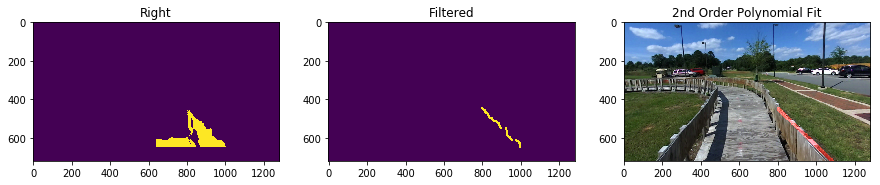

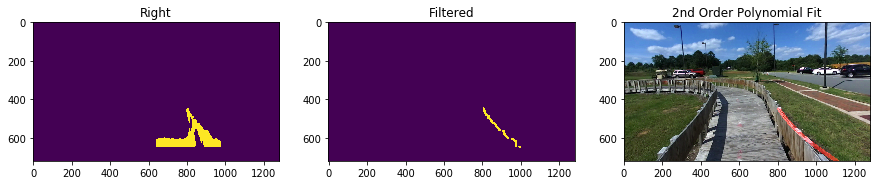

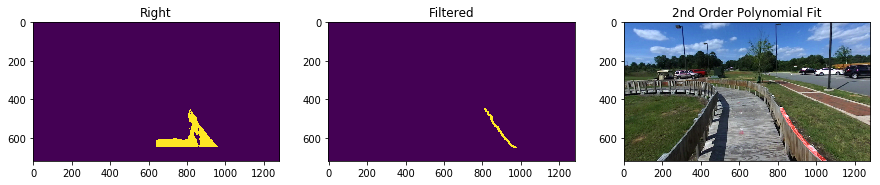

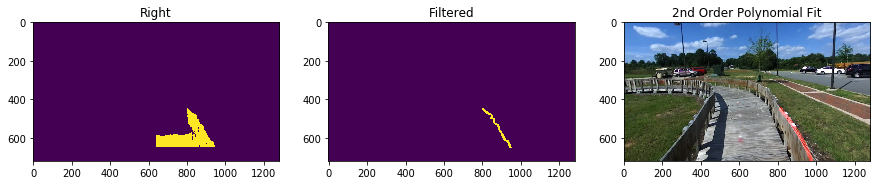

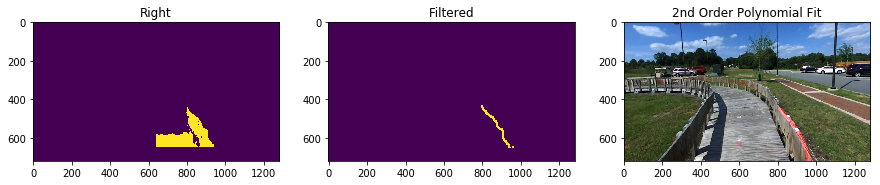

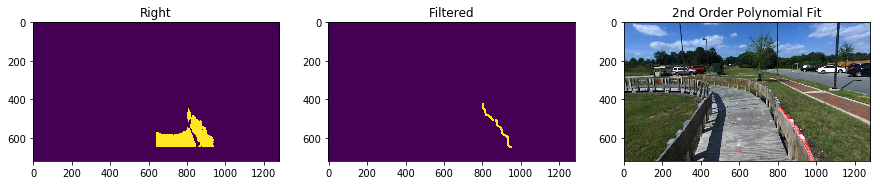

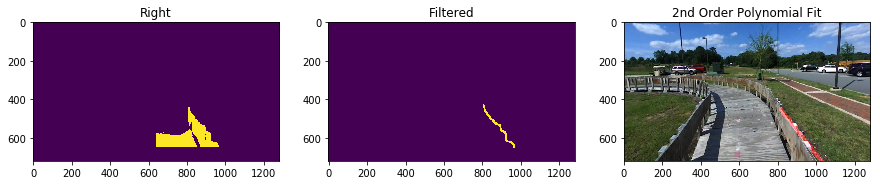

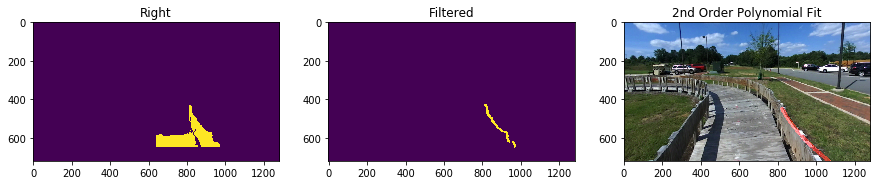

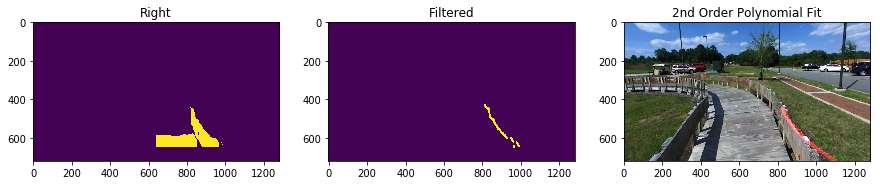

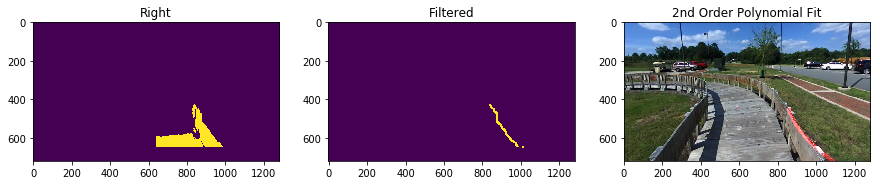

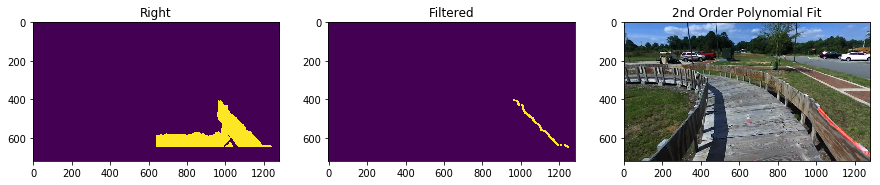

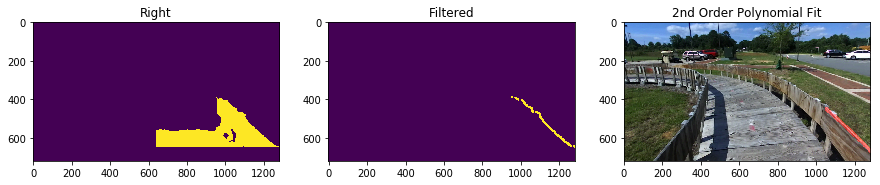

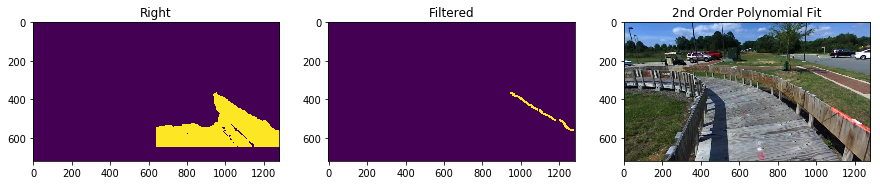

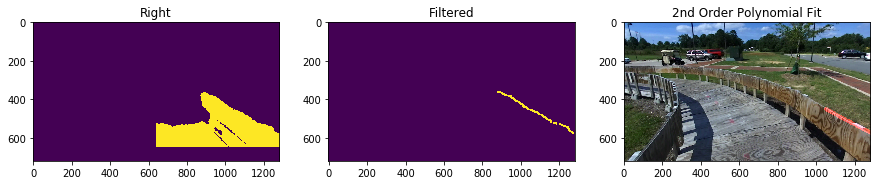

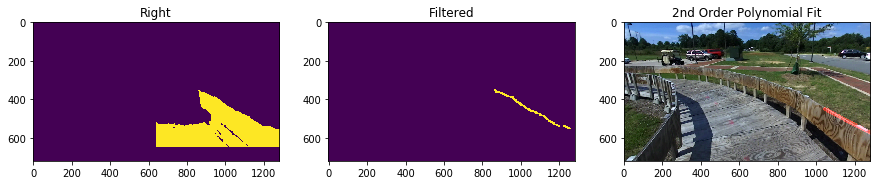

In [48]:
%matplotlib inline

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import csv
import re
import scipy.misc

def filterCoords3(nonzerox, nonzeroy, ymin, ymax):
    return np.array([[row, col] for row,col in zip(nonzeroy,nonzerox) if col > 640 and col <1275],dtype='float32')
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img,low_threshold, high_threshold)




yminimum = 400
image_names = glob.glob('Subset//image_left_*.jpg') 
depth_names = glob.glob('Subset//image_depth_*.jpg') 

processed ='processed/'
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

image_names = sorted(image_names, key=numericalSort)
depth_names = sorted(depth_names, key=numericalSort)

n=0

for image, depth in zip(image_names, depth_names):

    dpt_ = mpimg.imread(depth)
    img_ = mpimg.imread(image)

    dpt = dpt_

    gray = cv2.cvtColor(dpt, cv2.COLOR_BGR2GRAY)
    crop_low = np.zeros_like(gray)
    right = np.zeros_like(gray)
    binary = np.zeros_like(right)

    binary[gray > 80] = 1
    
    # right side of gradient
    crop_low[:650,:] = binary[:650,:]
    right[:,640:] = crop_low[:,640:]
    
    cols = np.argmax(np.fliplr(right)==1, axis = 1)
    coords= getCoords(cols)
    test = np.zeros_like(right)
    test[coords[0],coords[1]] = 1
    test = np.fliplr(test)
    
    kernel = np.ones((5,5),np.uint8)
    
    #image representing final filtered points
    test = cv2.dilate(test,kernel,iterations = 2)

    nonzero = test.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    nonzero = np.vstack(nonzero).T
    
    # Not currently used for viewing polynomials
    # Use for measuring correct distances
    xformed = cv2.perspectiveTransform(np.array([nonzero.astype(np.float32)]),M)
    xformed = xformed[0]

    poly = np.polyfit(nonzero[:,0],nonzero[:,1], 2)  
    
    right_fit = poly
    image = img_
  
    ploty = np.linspace(450, image.shape[0]-1, num=image.shape[0]-1-450)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    color_warp = np.zeros_like(image).astype(np.uint8)

    pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))], np.int32)
    cv2.polylines(color_warp,[pts],False,(255,0,0),20)
    result = cv2.addWeighted(image, 1, color_warp, 0.5, 0)

    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.set_title('Right')
    ax1.imshow(right)
    ax2.set_title('Filtered')
    ax2.imshow(test)    
    ax3.set_title('2nd Order Polynomial Fit')
    ax3.imshow(result)
    plt.savefig('filtering' + str(n) + '.png')
    
    n = n + 1